# Calculating the horizontal Turner Angle

## Table Of Contents: <a class="anchor" id="top"> </a>
* [Create region mask object](#region-mask) 
* [Make histogram of each term](#histogram-terms)
* [Calculate Horizontal Turner Angle](#turner-angle)

# 1) Calculate Horizontal Turner Angle <a class='anchor' id='turner-angle'></a>
$$Tu_h = atan2(\frac{\nabla \rho}{|\nabla \rho|} \cdot (\alpha \nabla T + \beta \nabla S), \frac{\nabla \rho}{|\nabla \rho|} \cdot (\alpha \nabla T - \beta \nabla S))$$

(Turner 1973, [Ruddick 1983](https://reader.elsevier.com/reader/sd/pii/0198014983900638?token=65952EBCA83FAAF5BF2480348931B38611B7AD90A9E27A17537E663CAF25691DF01538E4A5516463CD6E5ED33649AEEB&originRegion=us-east-1&originCreation=20220706161949), [Johnson et al., 2012](http://dx.doi.org/10.1029/2011JC007651))

- The atan() and atan2() functions calculate the arctangent of x and y/x, respectively. 
- The atan() function returns a value in the range -π/2 to π/2 radians. The atan2() function returns a value in the range -π to π radians. If both arguments of the atan2() function are zero, the function sets errno to EDOM, and returns a value of 0.

_Expanded form_

$$Tu_h = atan2(\frac{1}{|\nabla \rho|}\{\frac{\partial \rho}{\partial x}  [\alpha \frac{\partial T}{\partial x} + \beta \frac{\partial S}{\partial x}] + \frac{\partial \rho}{\partial y}  [\alpha \frac{\partial T}{\partial y} + \beta \frac{\partial S}{\partial y}]\}, \frac{1}{|\nabla \rho|}\{\frac{\partial \rho}{\partial x}  [\alpha \frac{\partial T}{\partial x} - \beta \frac{\partial S}{\partial x}] + \frac{\partial \rho}{\partial y}  [\alpha \frac{\partial T}{\partial y} - \beta \frac{\partial S}{\partial y}]\})$$

where,

$$\frac{1}{|\nabla \rho|} = \frac{1}{\sqrt{(\frac{\partial \rho}{\partial x})^2 + (\frac{\partial \rho}{\partial y}})^2}$$

In [20]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [39]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.f4bda5c530894f38a12146783391f261/status,


In [42]:
client.close()
cluster.close()

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import pop_tools
import json
import fsspec
import gcsfs
import xmitgcm
from xhistogram.xarray import histogram

In [2]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
cesm  = cat["CESM_POP_hires_control"].to_dask()
#workaround from Julius to make gradient func work quicker
ds_drop = cesm.drop([v for v in cesm.coords if v not in ['DXT', 'DXU', 'DYT', 'DYU']])

In [3]:
grid, ds_ren = pop_tools.to_xgcm_grid_dataset(ds_drop)

In [4]:
def horizontal_turner_angle():
    """Compute horizontal turner angle given SST and SSS, 
        and user-defined basin selection"""
    
    def gradient(da):
        """Compute the gradients of T, S and rho"""
        
        da_diffx = grid.diff(da, 'X')
        da_diffy = grid.diff(da, 'Y', boundary='fill')
        da_diffx_interp = grid.interp(da_diffx, 'X')
        da_diffy_interp = grid.interp(da_diffy, 'Y', boundary='fill')
        dadx = da_diffx_interp/ds_ren.DXT
        dady = da_diffy_interp / ds_ren.DYT
        return dadx, dady
    
    #create grad-rho and |grad-rho| terms
    #rho = jmd95numba.rho(ds_ren.SSS, ds_ren.SST, 0).load()
    rho = xr.apply_ufunc(jmd95numba.rho, ds_ren.SSS, ds_ren.SST, 0,
                     output_dtypes=ds_ren.SST.dtype,
                     dask='parallelized', vectorize=True).reset_coords(drop=True)
    gradrho = gradient(rho)
    modgradrho = 1 / np.sqrt(gradrho[0]**2 + gradrho[-1]**2)
    
    #create gradT and gradS
    gradT = gradient(ds_ren.SST)
    gradS = gradient(ds_ren.SSS)
    
    #define alpha and beta
    runit2mass = 1.035e3 #rho_0
    drhodt = xr.apply_ufunc(jmd95numba.drhodt, ds_ren.SSS, ds_ren.SST, 0,
                        output_dtypes=[ds_ren.SST.dtype],
                        dask='parallelized', vectorize=True).reset_coords(drop=True)#.load()
    drhods = xr.apply_ufunc(jmd95numba.drhods, ds_ren.SSS, ds_ren.SST, 0,
                        output_dtypes=[ds_ren.SSS.dtype],
                        dask='parallelized', vectorize=True).reset_coords(drop=True)#.load()
    alpha = - drhodt / runit2mass
    beta = drhods / runit2mass
    
    #define eq
    #gradrho[0/1] is selecting the dadx/dady output from `gradient` func above
    term1 = modgradrho*(gradrho[0]*(alpha*gradT[0] + beta*gradS[0]) + gradrho[1]*(alpha*gradT[1] + beta*gradS[1]))
    term2 = modgradrho*(gradrho[0]*(alpha*gradT[0] - beta*gradS[0]) + gradrho[1]*(alpha*gradT[1] - beta*gradS[1]))
    turner_angle = xr.ufuncs.arctan(term1, term2)
    
    return turner_angle

In [5]:
#weddell region
selection = dict(time=10, nlon_t=slice(470, 1000), nlat_t=slice(0,500))

#### Plot Turner angle

In [6]:
ta = horizontal_turner_angle()

/tmp/ipykernel_331/4172090642.py:43: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  turner_angle = xr.ufuncs.arctan(term1, term2)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/dataarray.py:3098: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  f(self.variable, other_variable)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/variable.py:2467: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  f(self_data, other_data) if not reflexive else f(other_data, self_data)


In [9]:
ta

<xarray.DataArray (time: 14965, nlat_t: 2400, nlon_t: 3600)>
dask.array<arctan, shape=(14965, 2400, 3600), dtype=float64, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 ... 3.598e+03 3.598e+03 3.6e+03
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 ... 2.398e+03 2.398e+03 2.4e+03
    DXT      (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT      (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: time

In [30]:
ta_new_coord = ta.assign_coords(coords={'time':cesm.time})
ta_new_coord_drops = ta_new_coord.drop([v for v in ta_new_coord.coords if v not in ['nlon_t', 'nlat_t', 'time']])

In [31]:
ta_new_coord_drops.time

<xarray.DataArray 'time' (time: 14965)>
array([cftime.DatetimeNoLeap(46, 1, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(46, 1, 3, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(46, 1, 4, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(86, 12, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(86, 12, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(87, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Attributes:
    bounds:     time_bound
    long_name:  time

In [32]:
ta_clim = ta_new_coord_drops.groupby('time.month').mean('time')

In [33]:
ta_clim

<xarray.DataArray (month: 12, nlat_t: 2400, nlon_t: 3600)>
dask.array<stack, shape=(12, 2400, 3600), dtype=float64, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 ... 3.598e+03 3.598e+03 3.6e+03
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 ... 2.398e+03 2.398e+03 2.4e+03
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

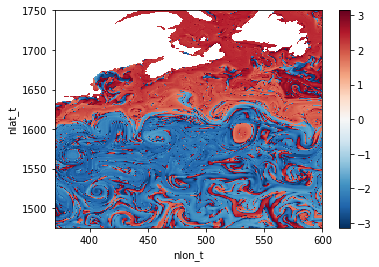

In [57]:
ta[10].isel(nlon_t=slice(370, 600), nlat_t=slice(1475,1750)).plot()

In [16]:
np.warnings.filterwarnings('ignore')

In [34]:
ta_deg1 = xr.ufuncs.degrees(ta)
ta_deg2 = xr.ufuncs.rad2deg(ta_clim)

/tmp/ipykernel_331/2030795447.py:1: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  ta_deg1 = xr.ufuncs.degrees(ta)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/dataarray.py:3078: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  da = self.__array_wrap__(f(self.variable.data, *args, **kwargs))
/tmp/ipykernel_331/2030795447.py:2: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  ta_deg2 = xr.ufuncs.rad2deg(ta_clim)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/dataarray.py:3078: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  da = self.__array_wrap__(f(self.variable.data, *args, **kwargs))


In [35]:
ta_deg1

<xarray.DataArray (time: 14965, nlat_t: 2400, nlon_t: 3600)>
dask.array<degrees, shape=(14965, 2400, 3600), dtype=float64, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 ... 3.598e+03 3.598e+03 3.6e+03
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 ... 2.398e+03 2.398e+03 2.4e+03
    DXT      (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT      (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: time

In [38]:
ta_deg2.isel(month=9)

<xarray.DataArray (nlat_t: 2400, nlon_t: 3600)>
dask.array<getitem, shape=(2400, 3600), dtype=float64, chunksize=(2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 ... 3.598e+03 3.598e+03 3.6e+03
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 ... 2.398e+03 2.398e+03 2.4e+03
    month    int64 11

KilledWorker: ("('open_dataset-5b10252e2fd008145fbc7138ea6d96b7SSS-defab81eca98ddcedc9fe042aea2a7b1', 7227, 0, 0)", <WorkerState 'tls://10.8.20.3:40347', name: dask-worker-f4bda5c530894f38a12146783391f261-clg2m, status: closed, memory: 0, processing: 576>)

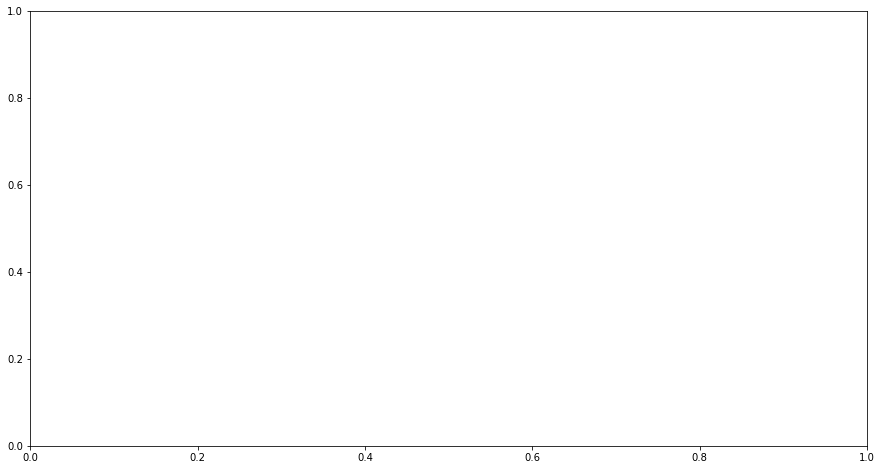

In [40]:
#global turner angle during Oct
fig, ax = plt.subplots(figsize=(15,8))
ta_deg2.isel(month=9).plot.contourf(levels=np.arange(-90, 90, 15), cmap='hsv');

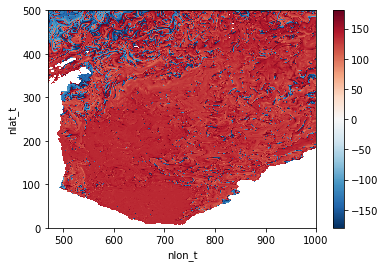

In [12]:
ta_deg1.isel(**selection).plot()

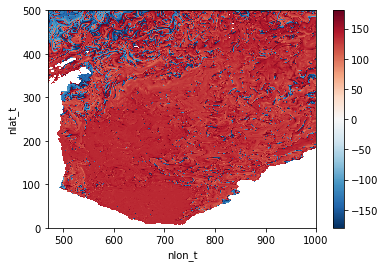

In [13]:
ta_deg2.isel(**selection).plot()

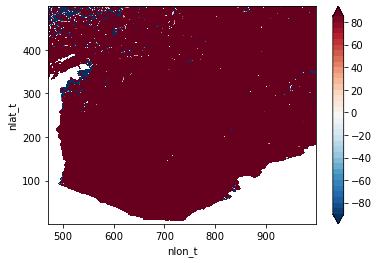

In [26]:
ta_deg1.isel(**selection).plot.contourf(levels=np.arange(-90, 90, 5));

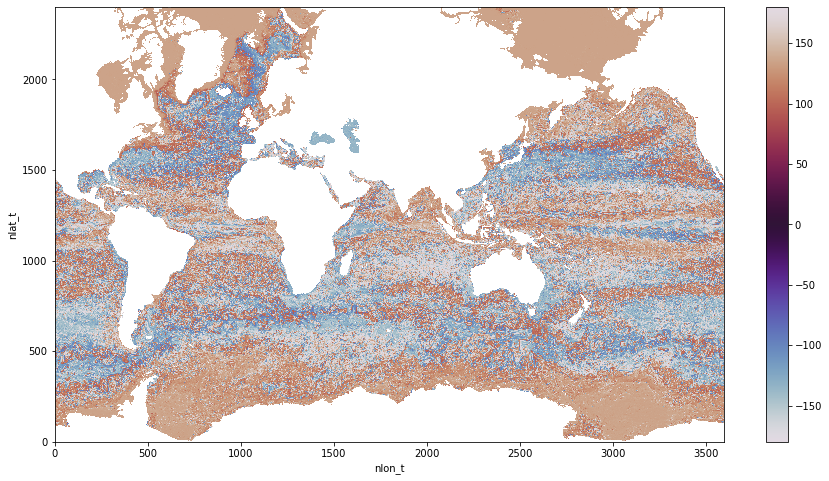

In [27]:
#global turner angle
ta_deg1[10].plot(figsize=(15,8), cmap='twilight')

Task exception was never retrieved
future: <Task finished name='Task-398' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py:2016> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py", line 2025, in wait
    raise AllExit()
distributed.client.AllExit


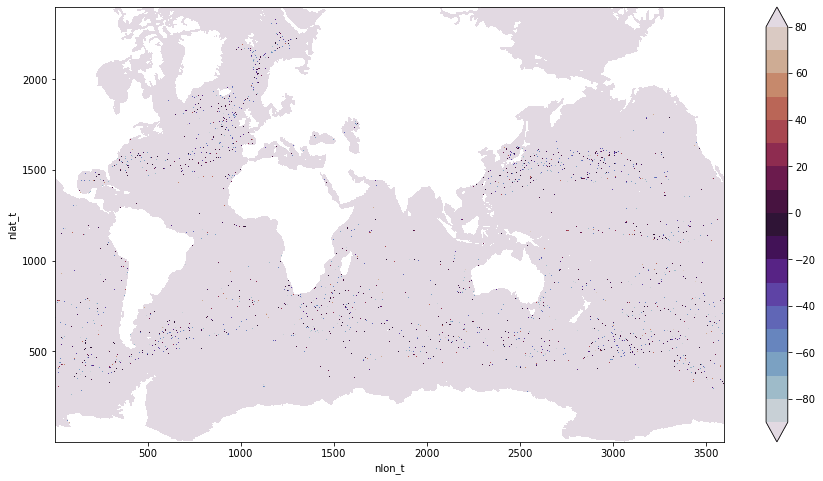

In [34]:
#global turner angle
fig, ax = plt.subplots(figsize=(15,8))
ta_deg1[10].plot.contourf(levels=np.arange(-90, 90, 10),  cmap='twilight', ax=ax);

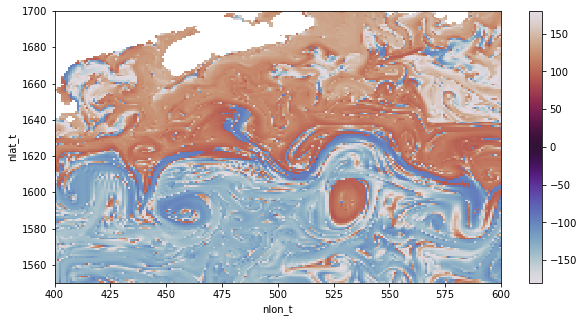

In [37]:
#Gulf stream
ta_deg1[10].isel(nlon_t=slice(400, 600), nlat_t=slice(1550, 1700)).plot(figsize=(10,5), cmap='twilight')

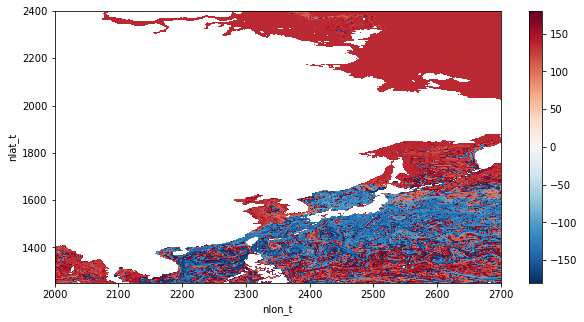

In [33]:
#russia's northwestern coast to compare with histogram subplts
ta_deg1[10].isel(nlon_t=slice(2000, 2700), nlat_t=slice(1250, 2400)).plot(figsize=(10,5))

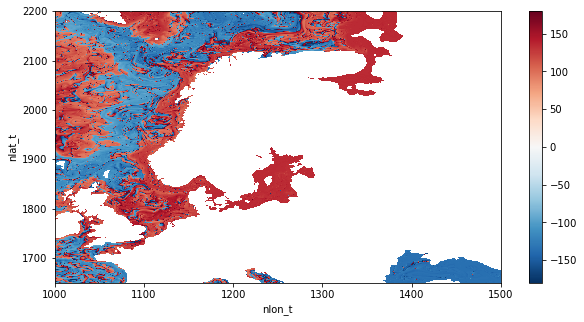

In [26]:
#mediterranean sea to compare with histogram subplots
ta_deg1[10].isel(nlon_t=slice(1000, 1500), nlat_t=slice(1650, 2200)).plot(figsize=(10,5))

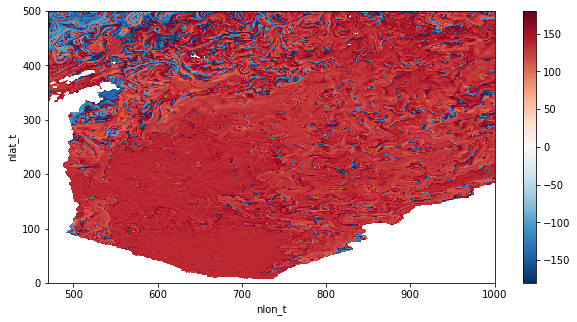

In [31]:
#weddell
ta_deg1.isel(**selection).plot(figsize=(10,5))

[Back to top](#top)